In [65]:
import os
import pandas as pd
import numpy as np
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scikit_posthocs as sp
from matplotlib import rcParams


In [2]:
os.chdir('/fs/ess/PAS0439/MING/virome/checkv_trimmed_for_dowmstream/AMG')

In [3]:
mapping_results = glob.glob('*/*.txt', recursive=True)

In [4]:
metadata = pd.read_csv('../../metadata.csv').drop(['project', 'file_path'], axis = 1)
metadata.set_index('id', inplace = True)

In [5]:
basepair={}
tmp = pd.read_csv('../ecology/samples_basepair.txt', sep = '\t', header = None)
for index, row in tmp.iterrows():
    basepair[row[0]] = row[1]

In [6]:
abundance = {}
for result in mapping_results:
    sample = result.split('/')[1].split('.txt')[0]
    df = pd.read_csv(result, sep='\t', names = ['votu', sample], skiprows=1)
    abundance[sample] = list(df[sample])
    myindex = df['votu']

In [7]:
table_pre = pd.DataFrame.from_dict(abundance)

In [8]:
table_pre.index = myindex

In [9]:
table_pre

,SRR4435562,SRR4435563,SRR4435572,HS.04,SRR12529324,Yak.AD03,SRR948124,SRR4435558,SRR4435580,SRR12529099,...,SRR11585797,ERR3801459,ERR2530126,SRR6197820,ERR2027901,ERR3275123,ERR3211463,ERR3211473,ERR3275115,SRR11585819
votu,,,,,,,,,,,,,,,,,,,,,
SRR4435578_293003||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0.0,0,0,0.0,0.0,0.0,0.0,7.644675,0.0
SRR12529099_2266573||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.287475,...,0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
SRR12529099_3215298||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.017044,...,0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
SRR12529099_3265256||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.372526,...,0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
SRR12529323_21716||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR4297109_1394665||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
ERR4297109_1407554||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
ERR4297109_1408828||full,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0


In [10]:
samples = list(table_pre.columns)

In [11]:
table_normalized = table_pre.copy()

In [12]:
for sample in samples:
    table_normalized.loc[:,sample] = table_normalized.loc[:, sample]/basepair[sample]*1000000000

In [13]:
amg = pd.read_csv('AMG_annotation_curated.csv')

In [14]:
conserved_amg = [] ## previously identified or seen in two vcontigs
with open('amg_gene_list_for_plot.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        conserved_amg.append(line.strip())

In [15]:
conserved_amg_decription = amg[amg.gene_description.isin(conserved_amg)][['scaffold', 'gene_description', 'category']]

In [16]:
genes = list(set(conserved_amg_decription.gene_description))

In [17]:
amg_ecology_pre = pd.merge(table_normalized, conserved_amg_decription, left_on='votu', right_on='scaffold')

In [18]:
reformated={} # sum same gene
for sample in samples:
    df = amg_ecology_pre.loc[:,[sample, 'gene_description', 'category']].groupby(['gene_description', 'category'])[sample].sum().reset_index().set_index('gene_description')
    result = list(df.loc[genes, sample])
    reformated[sample] = result
    

In [19]:
reformated_df = pd.DataFrame.from_dict(reformated)

In [20]:
reformated_df.index = genes

In [21]:
reformated_df

,SRR4435562,SRR4435563,SRR4435572,HS.04,SRR12529324,Yak.AD03,SRR948124,SRR4435558,SRR4435580,SRR12529099,...,SRR11585797,ERR3801459,ERR2530126,SRR6197820,ERR2027901,ERR3275123,ERR3211463,ERR3211473,ERR3275115,SRR11585819
Phosphopantetheine attachment site [PF00550.28]; Acyl-carrier [PF14573.9]; Ribosomal subunit 39S [PF10501.12],0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
small subunit ribosomal protein S6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
M95,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.059486,0.0,0.0
Rubrerythrin [PF02915.20],0.000000,0.0,0.581458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
adenylosuccinate synthase [EC:6.3.4.4] [RN:R01135],0.550506,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Phosphopantetheine attachment site [PF00550.28],0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
S-adenosylmethionine decarboxylase [PF02675.18],0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.301716,0.0,0.0,0.000000,0.0,0.0
Asparagine synthase [PF00733.24],0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
Enoyl-(Acyl carrier protein) reductase [PF13561.9],0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [22]:
gene_category = conserved_amg_decription[conserved_amg_decription.gene_description.isin(genes)][['gene_description', 'category']].drop_duplicates()

In [41]:
def present_absent(x):
    if x > 0:
        value = 1
    else:
        value = 0
    return value

In [42]:
reformated_df = reformated_df.applymap(present_absent)

In [23]:
metadata_dict = {}
for sample in samples:
    mydict = {'species': metadata.loc[sample, 'species'], 'beef_or_dairy': metadata.loc[sample, 'beef_or_dairy'], 'grazing_or_not': metadata.loc[sample, 'grazing_or_not'], 'geography': metadata.loc[sample, 'geography']}
    metadata_dict[sample] = mydict

In [24]:
metadata_reformat = pd.DataFrame.from_dict(metadata_dict)

In [25]:
amg_heatmap_pre = pd.merge(reformated_df, gene_category, left_index = True, right_on = 'gene_description').set_index('gene_description')

In [26]:
amg_heatmap_ready = pd.concat([amg_heatmap_pre, metadata_reformat])

In [99]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
amg_heatmap_ready.transpose().query('geography == "Kenya"').transpose()

,ERR4297095,ERR4297089,ERR4297106,ERR4297094,ERR4297107,ERR4297101,ERR4297104,ERR4297105,ERR4297091,ERR4297086,ERR4297093,ERR4297088,ERR4297097,ERR4297103,ERR4297108,ERR4297090,ERR4297102,ERR4297099,ERR4297092,ERR4297098,ERR4297100,ERR4297096,ERR4297109
Phosphopantetheine attachment site [PF00550.28]; Acyl-carrier [PF14573.9]; Ribosomal subunit 39S [PF10501.12],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
small subunit ribosomal protein S6,0.057414,0.0,0.0,0.0,0.0,0.0,0.0,0.182226,0.0,0.0,0.0,0.0,0.0,1.160985,0.031284,0.0,0.0,0.0,0.075984,0.0,0.0,0.0,0.015536
M95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rubrerythrin [PF02915.20],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adenylosuccinate synthase [EC:6.3.4.4] [RN:R01135],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042948,0.0,0.0,0.0,0.0,0.0,0.0,0.266136,0.0,0.0,0.0,0.0,0.0
Adenylate kinase [PF00406.25],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Queuosine biosynthesis protein QueC [PF06508.16],2.259367,0.0,0.754591,0.493366,1.004044,0.27021,0.0,0.032734,0.0,0.0,0.0,0.612778,2.02574,1.934606,0.402956,0.132513,0.526174,0.269476,0.20219,0.0,0.116342,0.0,0.0
Cobalamin biosynthesis protein CobT [PF06213.15],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dCTP deaminase [EC:3.5.4.13] [RN:R02325],0.14724,0.0,0.027991,0.333473,0.208975,0.0,0.082778,0.418958,0.0,0.066319,0.0,0.0,0.0,0.0,0.571893,0.133353,0.385496,0.0,0.0,0.250945,0.14415,0.0,0.144225


In [84]:
#amg_heatmap_ready.to_csv('amg_heatmap_ready.csv')

In [77]:
carbo_amg_pre = amg_heatmap_ready.query('category == "Carbohydrate utilization"').sum().reset_index().iloc[0:974, ].rename(columns = {'index': 'votu', 0: 'abundance'})
N_amg_pre = amg_heatmap_ready.query('category == "N utilization"').sum().reset_index().iloc[0:974, ].rename(columns = {'index': 'votu', 0: 'abundance'})

In [78]:
carbo_amg = pd.merge(carbo_amg_pre, metadata, left_on= 'votu', right_index=True)
N_amg = pd.merge(N_amg_pre, metadata, left_on= 'votu', right_index=True)

In [83]:
N_amg.query('geography == "Kenya"')

,votu,abundance,species,beef_or_dairy,grazing_or_not,collection_method,geography
280,ERR4297095,0.0,Bos_indicus,na,no,tube,Kenya
293,ERR4297089,0.018901,Bos_indicus,na,no,tube,Kenya
303,ERR4297106,0.504269,Bos_indicus,na,no,tube,Kenya
365,ERR4297094,0.035115,Bos_indicus,na,no,tube,Kenya
444,ERR4297107,0.0,Bos_indicus,na,no,tube,Kenya
468,ERR4297101,0.0,Bos_indicus,na,no,tube,Kenya
492,ERR4297104,0.0,Bos_indicus,na,no,tube,Kenya
531,ERR4297105,0.198793,Bos_indicus,na,no,tube,Kenya
535,ERR4297091,0.0,Bos_indicus,na,no,tube,Kenya
563,ERR4297086,0.0,Bos_indicus,na,no,tube,Kenya


In [58]:
carbo_amg['abundance'] = pd.to_numeric(carbo_amg['abundance'])

In [70]:
geography_df = carbo_amg[['geography', 'abundance']]

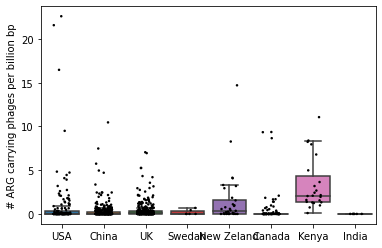

In [71]:
ax = sns.boxplot(x = 'geography', y='abundance', data= geography_df, fliersize = 0)
ax = sns.stripplot(x = 'geography', y='abundance', data= geography_df, color="black", jitter=0.2, size=2.5)
ax.set(xlabel='', ylabel='# ARG carrying phages per billion bp')
rcParams['figure.figsize'] = 5,3
#plt.savefig('country.svg', facecolor = 'w', edgecolor = 'w')

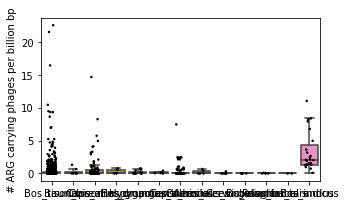

In [72]:
species_df = carbo_amg[['species', 'abundance']]
ax = sns.boxplot(x = 'species', y='abundance', data= species_df, fliersize = 0)
ax = sns.stripplot(x = 'species', y='abundance', data= species_df, color="black", jitter=0.2, size=2.5)
ax.set(xlabel='', ylabel='# ARG carrying phages per billion bp')
rcParams['figure.figsize'] = 5,3
#plt.savefig('country.svg', facecolor = 'w', edgecolor = 'w')

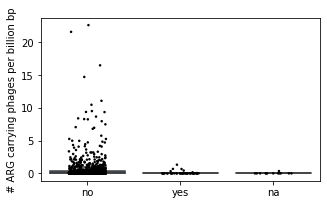

In [75]:
grazing_df = carbo_amg[['grazing_or_not', 'abundance']]
ax = sns.boxplot(x = 'grazing_or_not', y='abundance', data= grazing_df, fliersize = 0)
ax = sns.stripplot(x = 'grazing_or_not', y='abundance', data= grazing_df, color="black", jitter=0.2, size=2.5)
ax.set(xlabel='', ylabel='# ARG carrying phages per billion bp')
rcParams['figure.figsize'] = 5,3
#plt.savefig('country.svg', facecolor = 'w', edgecolor = 'w')

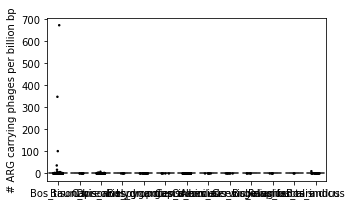

In [84]:
species_df_N = N_amg[['species', 'abundance']]
ax = sns.boxplot(x = 'species', y='abundance', data= species_df_N, fliersize = 0)
ax = sns.stripplot(x = 'species', y='abundance', data= species_df_N, color="black", jitter=0.2, size=2.5)
ax.set(xlabel='', ylabel='# ARG carrying phages per billion bp')
rcParams['figure.figsize'] = 5,3
#plt.savefig('country.svg', facecolor = 'w', edgecolor = 'w')

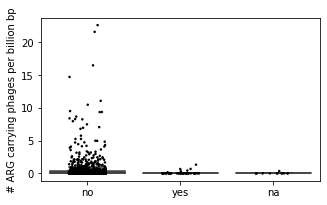

In [81]:
grazing_df_N = carbo_amg[['grazing_or_not', 'abundance']]
ax = sns.boxplot(x = 'grazing_or_not', y='abundance', data= grazing_df_N, fliersize = 0)
ax = sns.stripplot(x = 'grazing_or_not', y='abundance', data= grazing_df_N, color="black", jitter=0.2, size=2.5)
ax.set(xlabel='', ylabel='# ARG carrying phages per billion bp')
rcParams['figure.figsize'] = 5,3
#plt.savefig('country.svg', facecolor = 'w', edgecolor = 'w')

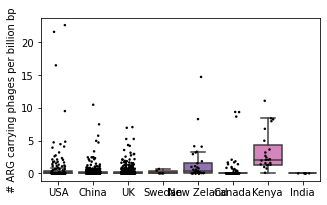

In [82]:
geography_df_N = carbo_amg[['geography', 'abundance']]
ax = sns.boxplot(x = 'geography', y='abundance', data= geography_df_N, fliersize = 0)
ax = sns.stripplot(x = 'geography', y='abundance', data= geography_df_N, color="black", jitter=0.2, size=2.5)
ax.set(xlabel='', ylabel='# ARG carrying phages per billion bp')
rcParams['figure.figsize'] = 5,3
#plt.savefig('country.svg', facecolor = 'w', edgecolor = 'w')